In [ ]:
! pip install langchain_openai langchain_community langchain_core -U

# function call 简介

LLM的Function Call（函数调用）是一种功能，允许大型语言模型（如GPT）在生成文本的过程中调用外部函数或服务。通过这种方式，开发者可以定义各种函数，使得LLM能够根据对话的上下文和需求进行调用。这些函数可以用于数据提取、知识检索和API集成等任务，从而增强LLM的能力。
具体来说，Function Call的作用包括：

- 准确识别用户意图：将用户的语义转化为结构化的指令，从而准确判断需要调用哪个函数及其参数。
- 增强对话能力：使得对话代理或聊天机器人能够处理复杂问题，通过调用外部API或知识库提供更相关和有用的响应。
- 解决模型的局限性：通过引入工具插件来解决模型在时间处理和专业知识方面的缺陷，如幻觉问题。
总结来说：function call能够让你用很少的提示词，让llm输出更加准确，数据结构更加稳定。



The general flow is this:

Generate tool calls with a chat model in response to a query.
Invoke the appropriate tools using the generated tool call as arguments.
Format the result of the tool invocations as ToolMessages.
Pass the entire list of messages back to the model so that it can generate a final answer (or call more tools).
Diagram of a complete tool calling flow

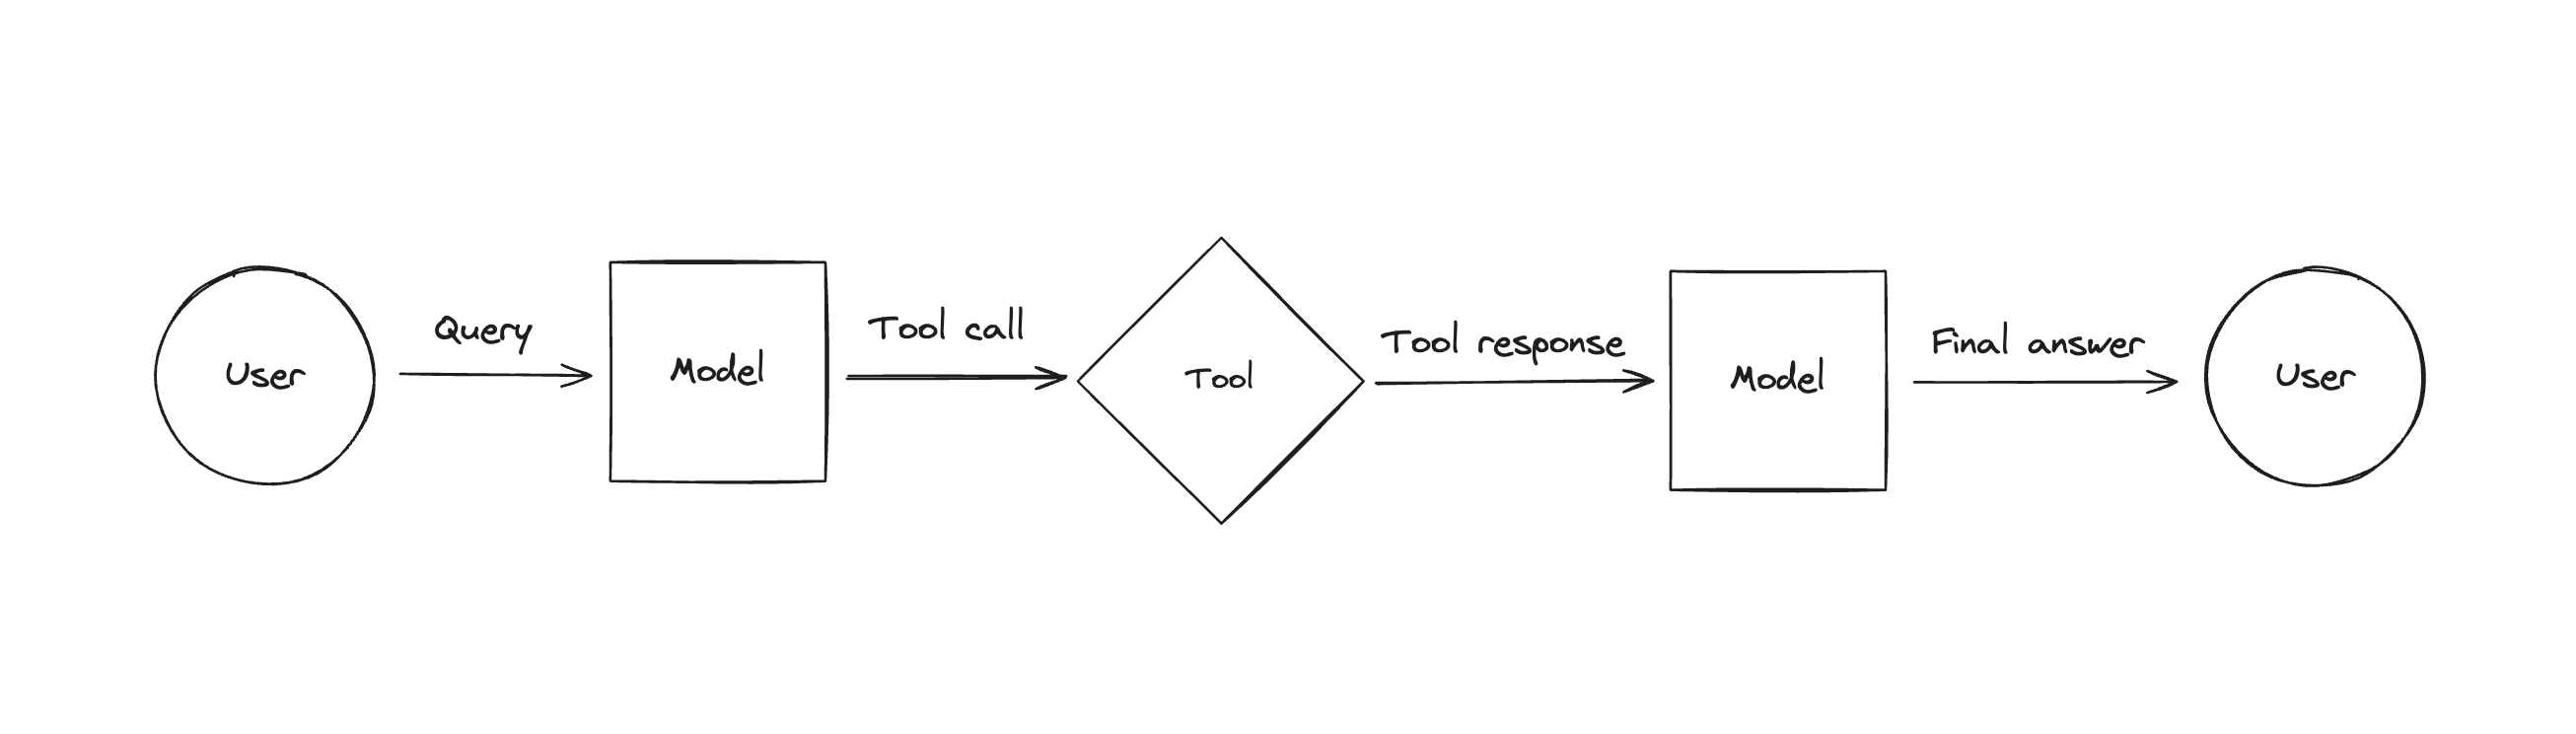



我们还是用几个场景示例来说明，需要实现的功能如下：

### 官网天气示例
试想一下，如果我们询问北京天气，我们要从一段内容中提取参数location，并调用get_current_weather，获取结果，需要怎么做。在上一小节中，我们学习了json mode能力，可以写提示词，让ai帮我们提取包含location的对象，然后再传给函数得到结果，使用function calling该怎么实现呢。

> 我们使用function_calling，把这个函数的描述告诉大模型，它就会返回给你这个函数所需要的参数。这个过程就会变得简洁、可控，结果更加准确。使用过程如下

In [ ]:
from langchain_openai import ChatOpenAI
from google.colab import userdata
import os

os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                },
                "required": ["location"],
            },
        },
    }
]

model = ChatOpenAI(model="qwen2.5-72b-instruct").bind_tools(tools)
res = model.invoke("北京的天气怎么样")
print(res.tool_calls[0]["name"])
print()
print(res.tool_calls[0]["args"])



### 数学运算示例

上一个例子中，我们手写了json_schema来描述函数。但是，我们不能每次都自己手动做这件事，这样成本会变得很高。langchain提供了tool修饰符，可以增强工具，并允许大模型来绑定这些工具。在调用大模型时，自动帮我们生成json_schema。

有一个计算函数，它接受两个整数参数 a 和 b，并返回它们的乘积。

In [ ]:
def amultiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

In [ ]:
from langchain_core.tools import tool
from google.colab import userdata
from langchain_openai import ChatOpenAI

# 定义一个工具函数，用于计算两个数的乘积
@tool
def amultiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b

import os
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)

# 将定义的工具函数绑定到模型上
ll_tool = llm.bind_tools([amultiply])

# 调用模型，传入参数并获取结果
result = ll_tool.invoke('a 为 3 b 是 6')

# 检查结果中是否包含工具调用，并打印相关信息
if hasattr(result, 'tool_calls') and result.tool_calls:
    print(result.tool_calls[0]['args'])  # 打印工具调用的参数
    print(type(result.tool_calls[0]['args']))  # 打印参数的类型

    # 调用 amultiply 工具函数，传入解析后的参数并打印结果
    print(amultiply.invoke(result.tool_calls[0]['args']))
else:
    print(result.content)  # 如果没有工具调用，则打印内容

In [ ]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langchain_core.tools import tool
from google.colab import userdata
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

import os
os.environ["OPENAI_API_BASE"] = userdata.get('OPENAI_API_BASE')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


idl1 = """
message ToolRequest {
    string tool_id = 1;  // 工具的唯一标识符
    int32 version = 2;   // 工具的版本号
}
"""

idl2 = """
message ToolRequest {
    string tool_name = 1;  // 工具的名称
    int32 version = 2;     // 工具的版本号
}
"""

idl3 = """
message ToolRequest {
    string tool_category = 1;  // 工具的类别
    int32 version = 2;         // 工具的版本号
}
"""

idl4 = """
message ToolRequest {
    string tool_description = 1;  // 工具的描述信息
    int32 version = 2;            // 工具的版本号
}
"""

class InterfaceDefinition(TypedDict):
    path: str
    description: str

class PSMDefinition(TypedDict):
    name: str
    interfaces: List[InterfaceDefinition]


interfaceMap: List[PSMDefinition] = [
    {
        "name": "anchor.psm1",
        "interfaces": [
            {
                "path": "/ark/anchor1",
                "idl": idl1
            },
            {
                "path": "/ark/anchor2",
                "idl": idl2
            },
        ],
    },
    {
        "name": "webcast.psm2",
        "interfaces": [
            {
                "path": "/webcast/tool1",
                "idl": idl3
            },
            {
                "path": "/webcast/tool2",
                "idl": idl4
            },
        ],
    },
]

def find_idl_by_name_and_path(psm, path):
    for psmInfo in interfaceMap:
        if psmInfo["name"] == psm:
            for interface in psmInfo["interfaces"]:
                if interface["path"] == path:
                    return interface["idl"]

class ConfigDict(BaseModel):
    path: str = Field(description="包含 path 和 psm 的字典")
    psm: str = Field(description="接口对应的psm，示例：aaa.bbb.ccc，字母和.组成")

class ExplainKeyByPathInput(BaseModel):
    queryInfo: ConfigDict = Field(description="包含 path 和 psm 的字典")
    keyName: str = Field(description="字段名称")

@tool("explain-key-by-path", args_schema=ExplainKeyByPathInput)
def explain_key_by_path(
    queryInfo: ConfigDict,  # 定义一个包含 path 和 psm 的字典
    keyName: Annotated[str, "字段名称"],
):
    """字段解释工具，通过接口地址和接口对应的psm查找接口定义，并根据字段名来获取字段说明"""
    # 你可以选择不使用 config 参数
    print(queryInfo)
    idl = find_idl_by_name_and_path(**queryInfo.dict())  # 将 ConfigDict 转换为字典

    return idl

print(explain_key_by_path.args_schema.schema())

llm2 = ChatOpenAI(model="qwen2.5-72b-instruct", temperature=0)

llm_tool = llm2.bind_tools([explain_key_by_path])

result = llm_tool.invoke('查询psm:webcast.psm2 接口 /webcast/tool2 中的 tool_name字段')

if hasattr(result, 'tool_calls') and result.tool_calls:
    print(result.tool_calls[0]['args'])
    print(explain_key_by_path.invoke(result.tool_calls[0]['args']))
else:
    print(result.content)



# # 示例使用
# name = "anchor.psm1"
# path = "/ark/anchor2"
# idl = find_idl_by_name_and_path(name, path)
# print(idl)  # 输出: idl1


